# Statistical Rethinking, Section 4.3
* NOTE: My code does the same computations as the Statistical Rethinking python resource\*, but I have changed some of the variable names and syntax to make the code more understandable to me.

\* https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_04.ipynb

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import griddata

In [2]:
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['font.size'] = 18

# Display all outputs, not just the last line:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Model height using a Gaussian distribution

## Get data

In [3]:
url = \
'https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking_2/Data/Howell1.csv'

df = pd.read_csv(url, delimiter=';')
df.head()
df.info()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


In [4]:
df2 = df[df.age >= 18]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  352 non-null    float64
 1   weight  352 non-null    float64
 2   age     352 non-null    float64
 3   male    352 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 13.8 KB


## Choose a model

### Since "height is a sum of many small growth factors"\*, we choose to model height with a Gaussian distribution.

### Formally, 
$h_i \thicksim$ Normal$(\mu, \sigma)$

\*Statistical Rethinking 4.3.2

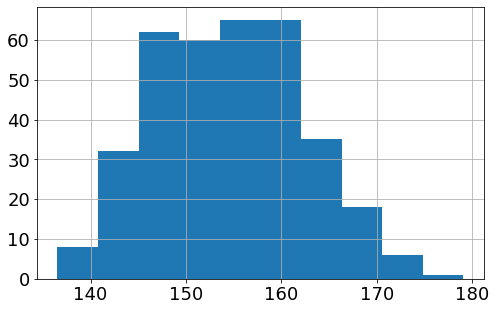

In [5]:
df2.height.hist()

## Choose priors

### Prior for the distribution of the mean of the heights

#### We expect the mean of the heights to also be normally distributed.

#### Our prior guess for the mean of the *distribution of the mean of the heights* is 158 cm--I picked this prior because I am 5'2", or about 158 cm tall. 

#### Our guess for the standard deviation of the mean is 20 cm--if we expect one standard deviation to be 20 cm, then that also means we expect 95% of heights to fall in the range 158 cm $\pm$ 40cm, or 118 cm to 198 cm (3'10" to 6'6"), which we know from experience is a fairly encompassing range for human heights, and a very wide range for the mean of the heights.

$\mu \thicksim$ Normal$(158, 20)$

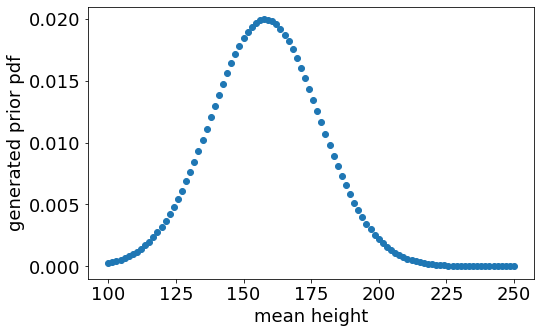

In [6]:
x = np.linspace(100, 250, 100)
y = stats.norm.pdf(x, 158, 20)
plt.scatter(x, y)
plt.xlabel('mean height');
plt.ylabel('generated prior pdf');

### Prior for the distribution of the standard deviation of the heights

"A standard deviation like σ must be positive, so bounding it at zero makes sense. How should we pick the upper bound? In this case, a standard deviation of 50cm would imply that 95% of individual heights lie within 100cm of the average height. That’s a very large range."\*

$\sigma \thicksim$ Uniform$(0, 50)$

\*Statistical Rethinking 4.3.2

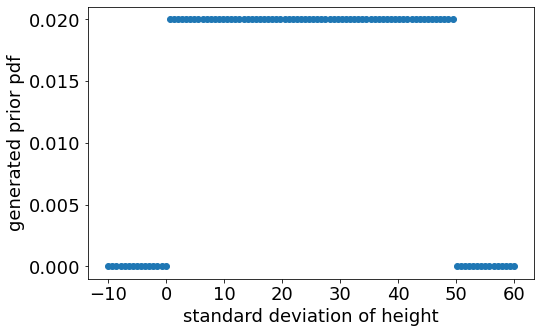

In [7]:
x = np.linspace(-10, 60, 100)
y = stats.uniform.pdf(x, 0, 50)
plt.scatter(x, y)
plt.xlabel('standard deviation of height');
plt.ylabel('generated prior pdf');

### Putting things together--Generate a prior height distribution using assumptions about the distributions of the parameters (mean and std) of the prior height distribution.
* Bayesian models involve layers of distributions, which can quickly get confusing. We have to keep track of many layers, and sample from those layers to make the next layer.
* Commonly, the output of a Bayesian model is a list of samples--these output samples represent a distribution. We could alternately use analytical equations to represent distributions, but these can be difficult or impossible to compute. Instead, we can use a list of samples to represent any arbitrary distribution, regardless of how analytically complex it may be.
* In this section, we generate a list of samples that represent a prior distribution.
    * Above, we decided to model height using a normal distribution.
        * The normal distribution has two parameters that also need to be modeled--mean and standard deviation.
    * Next, we made some assumptions about the mean and std:
        * We think the mean of height comes from a normal distribution with mean 158cm and std 20cm.
        * We think the std of height comes from a uniform distribution between 0 and 50 cm.
    * Generate samples
        * First, generate samples for the parameter distributions (mean of height and standard deviation of height).
        * Then, use those parameter samples to generate samples of the prior height distribution.

### Generate lists of values representing samples of the mean and standard deviation

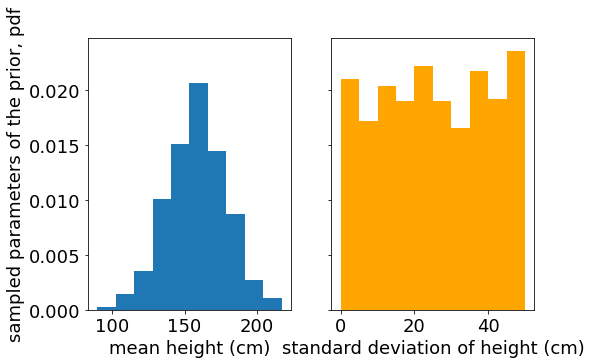

In [10]:
n_samples = 1000

# rvs generates a random sample from the specified distribution.
sample_mu = stats.norm.rvs(loc=158, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(sample_mu, density=True);
ax2.hist(sample_sigma, density=True, color='orange');
ax1.set_xlabel('mean height (cm)');
ax2.set_xlabel('standard deviation of height (cm)');
ax1.set_ylabel('sampled parameters of the prior, pdf');

### Use the samples of mean and standard deviation to compute samples of the prior distribution for height.
* prior_h is a list of samples.
* prior_h is sampled from a normal distribution.
* Each individual sample in prior_h is sampled using one of the sample_mu, sample_sigma pairs as the mean and std of the normal distribution.
* For example, the first value in the list prior_h was calculated by taking the first sample in the list sample_mu, and the first value in the list sample_sigma, and using those two  values to define the mean and std of a normal distribution, and then sampling one value from that normal distribution.

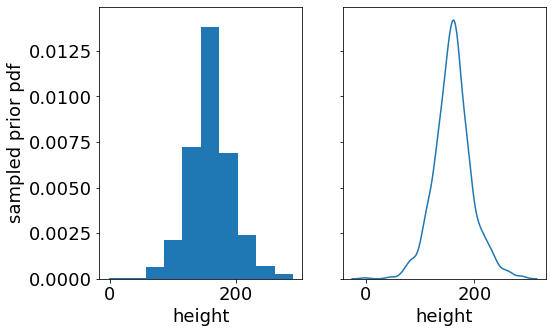

In [9]:
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(prior_h, density=True);
# az.plot_kde(prior_h)
sns.kdeplot(prior_h, ax=ax2);
ax1.set_xlabel('height');
ax2.set_xlabel('height');
ax1.set_ylabel('sampled prior pdf');

In [24]:
# prior_h is just a list of prior height estimate samples.
np.shape(prior_h)
prior_h

(1000,)

array([163.72870701, 146.46644297, 124.08516479, 145.90799998,
       171.97730582, 173.13072008, 129.80397697, 111.54217196,
       189.32507934, 157.82455477, 153.53823287, 147.77348761,
       124.7193671 , 155.79683071, 201.34317012, 161.12877782,
       180.48709636, 165.69157201, 165.27240076, 153.92247161,
       166.37536673, 189.63799977, 139.72645237, 119.70925986,
       129.93401772, 166.47256395, 151.66268194, 170.30949086,
       110.03751417, 157.51354874, 172.10016215, 158.83921021,
       166.00125962, 197.72866345, 164.20450281, 222.54469362,
       140.86277387, 197.18164001, 117.07387709, 102.97941444,
       131.01259952, 164.24931774, 225.63219842, 217.93531729,
        83.29066828, 187.85854191, 203.19048713, 134.04040934,
       195.11010583, 158.83105674, 151.0329532 , 165.06010383,
       148.90592173, 136.45976864, 169.77304567, 117.43441238,
       170.87114774, 188.89105705, 163.27591283, 193.16737117,
       131.77626561, 160.87293964, 170.36318559, 183.42

### Am I sure that stats.norm.rvs can have lists as the loc and scale inputs, and that it works the way I think it does?
* Let's find out!
    * Yep, it works!

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10

(array([ 6., 47., 40.,  6.,  1.,  0.,  2., 29., 53., 16.]),
 array([-1.7057582 , -0.29539286,  1.11497247,  2.52533781,  3.93570314,
         5.34606848,  6.75643381,  8.16679915,  9.57716448, 10.98752982,
        12.39789515]),
 <a list of 10 Patch objects>)

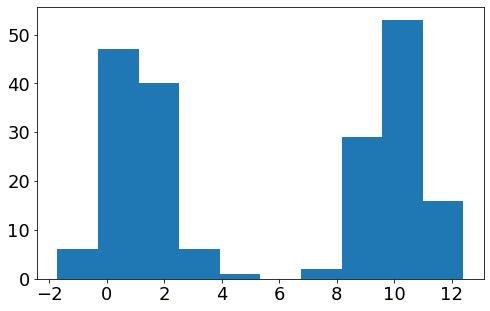

In [22]:
# Create a list containing two different values for the mean
d1m = 1  # Mean of distribution 1
d2m = 10 # Mean of distribution 2
m = np.concatenate([np.ones(100)*d1m, np.ones(100)*d2m])
m

# List of standard deviations, all ones
s = np.ones(200)

# If stats.norm.rvs works the way I think it does (by going down the lists of the parameters
#  and using each unique parameter pair to generate a sample) then we should see two distinct
#  distributions, one centered at d1m and another centered at d2m.
test_samples = stats.norm.rvs(loc=m, scale=s)
plt.hist(test_samples)

## 4.3.3 Use Grid Approximation to calculate the posterior 
* We calculate posterior likelihoods of particular values of the mean and standard deviation, given the data we observed and our prior expectations.

### Creat a grid of mean and standard deviation values that we will brute-force calculate likelihoods over. (We then flatten the grid to just two columns to simplify computation.)
* param_values is an array with two columns. 
* param_values contains all the combinations of parameter values between the specified ranges, as created by mgrid (aka mesh grid), but then flattened to just two columns. 
* The first column represents values of the mean, and the second column represents values of the standard deviation.

In [22]:
param_values = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T
param_values[0:100]

array([[150.  ,   7.  ],
       [150.  ,   7.05],
       [150.  ,   7.1 ],
       [150.  ,   7.15],
       [150.  ,   7.2 ],
       [150.  ,   7.25],
       [150.  ,   7.3 ],
       [150.  ,   7.35],
       [150.  ,   7.4 ],
       [150.  ,   7.45],
       [150.  ,   7.5 ],
       [150.  ,   7.55],
       [150.  ,   7.6 ],
       [150.  ,   7.65],
       [150.  ,   7.7 ],
       [150.  ,   7.75],
       [150.  ,   7.8 ],
       [150.  ,   7.85],
       [150.  ,   7.9 ],
       [150.  ,   7.95],
       [150.  ,   8.  ],
       [150.  ,   8.05],
       [150.  ,   8.1 ],
       [150.  ,   8.15],
       [150.  ,   8.2 ],
       [150.  ,   8.25],
       [150.  ,   8.3 ],
       [150.  ,   8.35],
       [150.  ,   8.4 ],
       [150.  ,   8.45],
       [150.  ,   8.5 ],
       [150.  ,   8.55],
       [150.  ,   8.6 ],
       [150.  ,   8.65],
       [150.  ,   8.7 ],
       [150.  ,   8.75],
       [150.  ,   8.8 ],
       [150.  ,   8.85],
       [150.  ,   8.9 ],
       [150.  ,   8.95],


### For one specific combination of parameter values, calculate the total log-likelihood of observing all of the height data values.
* norm.logpdf returns the log of the probability of observing a particular data value (in our case a height value), assuming that the height came from a normal distribution with the given mean and standard deviation.
* sum(LL) is the log-likelihood for a single pair of mean and standard deviation values.
    * We take all of the data values of height, and for each one we calculate the log-likelihood (using logpdf) of seeing that height value, if we were had pulled that height value from a normal distribution with a specific mean and standard deviation.
    * Then we add up all of those log-likelihoods, which is the same as multiplying all of the  likelihoods and then taking the log of the product. 
        * We want to multiply the likelihoods because we want to know the final probability of seeing the first data value of height AND the second data value of height AND the third data value of height... etc. 
        * So we are essentially trying to calculate p(h1)\*p(h2)\*p(h3)...\*p(hn), but we use logs because when we multiply probabilities we can get very small numbers, and the computer has trouble keeping track of those, and can have rounding errors.
        * Of course, multiplying the probabilities like this to get the total probability assumes that all of the height measurements are independent, that is, p(A AND B) = p(A)\*p(B) if A and B are independent. What do you do if the measurements are not independent?
* The likelihood is the probability of seeing all of these specific height data values, given a specific pair of mean and variance values.

In [36]:
LL = stats.norm.logpdf(df2.height, loc=param_values[1, 0], scale=param_values[1, 1])
LL[0:10]

total_LL = sum(LL)
total_LL

array([-2.90330487, -3.93921629, -4.69859082, -3.3433109 , -3.08344671,
       -4.79610377, -2.87800835, -6.46925099, -2.91403672, -5.16571395])

-1297.428225106116

### Building off of the last cell, now we calculate a list of log-likelihoods--one for each combination of mean and variance.
* As shown above, the sum calculates total log likelihood for one specific pair of mean and standard deviation values, but over all of the height data values.
* The for loop then calculates one total log likelihood value for each mean and standard deviation value pair.

In [32]:
log_likelihoods = [
    sum(stats.norm.logpdf(df2.height, loc=param_values[i, 0], scale=param_values[i, 1]))
    for i in range(len(param_values))
]
log_likelihoods[0:10]

[-1299.030295605718,
 -1297.428225106116,
 -1295.8949193620315,
 -1294.428216599498,
 -1293.0260332478672,
 -1291.6863606446127,
 -1290.407261899476,
 -1289.1868689093246,
 -1288.0233795154786,
 -1286.9150547958013]

### Calculate the log-likelihoods of each prior value for mean and standard deviation.
* Our prior expectations are that the mean of the heights comes from a normal distribution with its own mean of 178 cm and standard deviation of 20 cm. (Note that these mean of the mean and standard deviation of the mean are different from the mean and standard deviations of the height in param_values!) We expect the standard deviation of the heights to come from a uniform distribution from 0 to 50 cm.
* Remember that param_values has only two columns, but that the two columns together provide every combination of mean and standard deviation. This means that the values in both columns repeat, so the computation below is somewhat inefficient because it computes the logpdf for the same values multiple times. However, it doesn't slow us down too much, and it's easy to write and understand.

In [43]:
# Prior log-likelihood of the mean of the heights
log_prior_mean = stats.norm.logpdf(param_values[:, 0], loc=178, scale=20)
log_prior_mean

# Prior log-likelihood of the standard deviation of the heights
log_prior_std = stats.uniform.logpdf(param_values[:, 1], loc=0, scale=50)
log_prior_std

array([-4.89467081, -4.89467081, -4.89467081, ..., -4.32192393,
       -4.32192393, -4.32192393])

array([-3.91202301, -3.91202301, -3.91202301, ..., -3.91202301,
       -3.91202301, -3.91202301])

### Add the calculated log-likelihoods of the heights to the log-likelihoods of the mean and standard deviation.
* Remember that each of these log-likelihoods is in a list-like format, where each value in the list represents a likelihood for one pair of mean and standard deviation values.

In [44]:
post_prod = (
    log_likelihoods
    
    # Logs of the prior likelihoods for the mean and standard deviation:
    + stats.norm.logpdf(param_values[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(param_values[:, 1], loc=0, scale=50)
)
post_prod

array([-1307.83698942, -1306.23491892, -1304.70161317, ...,
       -1297.91333993, -1297.67006264, -1297.45288479])

### Transform the log-likelihoods into relative likelihoods
* First, subtract the maximum value from all the values 
    * This is mathematically the same as dividing all the likelihoods by the maximum likelihood.
    * We do this because the actual probabilities involved are too small for the computer to represent digitally.

In [54]:
relative_post_prob = np.exp(post_prod - max(post_prod))
relative_post_prob

# Note how simply taking the exponent of post_prod produces a vector of 0's, 
# because of the very small probabilities involved.
np.exp(post_prod)

array([1.95774597e-35, 9.71687726e-35, 4.50228456e-34, ...,
       3.99523704e-31, 5.09561418e-31, 6.33163222e-31])

array([0., 0., 0., ..., 0., 0., 0.])

### Repeat the last few sections of code, all together, and then plot the result.
#### Questions
* I'm confused about how we add together the likelihoods--It seems weird somehow that we are starting with the likelihoods of the prior parameters, and then just adding on likelihoods of the height data? It just seems weird that we can add those things together? Like why didn't we calculate some prior likelihoods for height values, and then add that to likelihoods for data height values?
* Where is the output of posterior samples? Or are the relative post probabilities the outputs in this section? Can we not sample from the posterior somehow? Or can we only do that with quap?

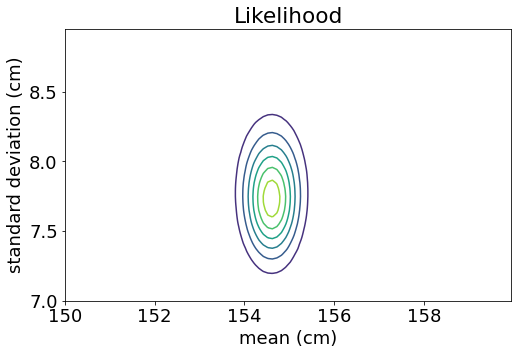

In [55]:
# Create a grid of parameter values for the mean and standard deviation,
# then flatten to just two columns.
param_values = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

# Compute a list of log-likelihood for each value pair of mean and standard deviation.
log_likelihoods = [
    sum(stats.norm.logpdf(df2.height, loc=param_values[i, 0], scale=param_values[i, 1]))
    for i in range(len(param_values))
]

# Add the log-likelihoods of the height data to the prior likelihoods of the 
# mean and standard deviation. 
# (Recall that adding logs is the same as multiplying the values inside the logs.)
post_prod = (
    log_likelihoods
    
    # Logs of the prior likelihoods for the mean and variance:
    + stats.norm.logpdf(param_values[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(param_values[:, 1], loc=0, scale=50)
)

# Transform the posterior log-likelihoods to relative likelihoods.
relative_post_prob = np.exp(post_prod - max(post_prod))

# Plot each likelihood value against its corresponding mean and standard deviation pair.
xi = np.linspace(param_values[:, 0].min(), param_values[:, 0].max(), 100)
yi = np.linspace(param_values[:, 1].min(), param_values[:, 1].max(), 100)
zi = griddata(
    (param_values[:, 0], param_values[:, 1]), relative_post_prob, (xi[None, :], yi[:, None])
)
plt.contour(xi, yi, zi);
plt.xlabel('mean (cm)');
plt.ylabel('standard deviation (cm)');
plt.title('Likelihood');

# 4.3.4 Sampling from the posterior

# 4.3.5 Finding the posterior distribution with quap

# TODO
* Reread from section 4.3.2 onwards, review and try to answer questions I wrote before.

# Questions
Why these particular ranges for the generated priors?
How are the priors going to be used?
So when we plotted the priors for the distributions of the mean and standard deviation of the heights, we just plotted ideal pdfs--I guess we were just plotting the 'true' distributions that we're guessing those values come from, and then when we actually sampled the priors, we sampled from those ideal distributions.
Review the equation in *Overthinking: Model definition to Bayes’ theorem again*